# Week 3: Clustering and Topic Modeling
### _Sushmita V Gopalan_
### Exercise 1

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json
import gzip
import pandas as pd
import datetime
import warnings


np.random.seed(4234)


This data consists of Amazon reviews on the following 4 categories of products
* Kindle Store
* Home and Kitchen
* Health and Personal Care
* Baby

The data are obtained from http://jmcauley.ucsd.edu/data/amazon/ 
The zip files are too large to upload to Github!

In [2]:
# get data
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

baby_df = getDF("reviews_Baby_5.json.gz")
kindle_df = getDF("reviews_Kindle_Store_5.json.gz")
health_df = getDF("reviews_Health_and_Personal_Care_5.json.gz")
home_df = getDF("reviews_Home_and_Kitchen_5.json.gz")



In [81]:
baby = baby_df.sample(500)
kindle = kindle_df.sample(500)
home = home_df.sample(500)
health = health_df.sample(500)

baby['source'] = "baby"
kindle['source'] = 'kindle'
home['source'] = 'home'
health['source'] = 'health'

df = baby.append([kindle,home,health])
df = df[['overall','reviewText','source','reviewerName']]
df.to_csv("reviews", sep='\t', encoding='utf-8')

In [ ]:
# create count vector
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
newsgroupsVects = ngCountVectorizer.fit_transform(df['reviewText'])

# tf-idf
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)

# vectorize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.3, max_features=1000, min_df=3, stop_words='english', norm='l2')
newsgroupsTFVects = ngTFVectorizer.fit_transform(df['reviewText'])


# k-means
numClusters = len(set(df['source']))

km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsgroupsTFVects)


In [167]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')


Top terms per cluster:
Cluster 0:
 story
 read
 series
 love
 characters
 books
 author
 book
 loved
 good


Cluster 1:
 use
 great
 product
 like
 good
 just
 works
 easy
 really
 work


Cluster 2:
 baby
 34
 seat
 little
 soft
 just
 car
 months
 love
 like


Cluster 3:
 book
 read
 reading
 series
 8217
 love
 loved
 story
 author
 life




### Clusters 0 and 3 appear to correspond to 'kindle' and Cluster 2 appears to correspond to 'baby', while Cluster 1 could be either 'home' or 'health'.

In [168]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

colordict = {'baby': 'red','health': 'orange','home': 'green','kindle': 'pink',}
colors = [colordict[c] for c in df['source']]
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

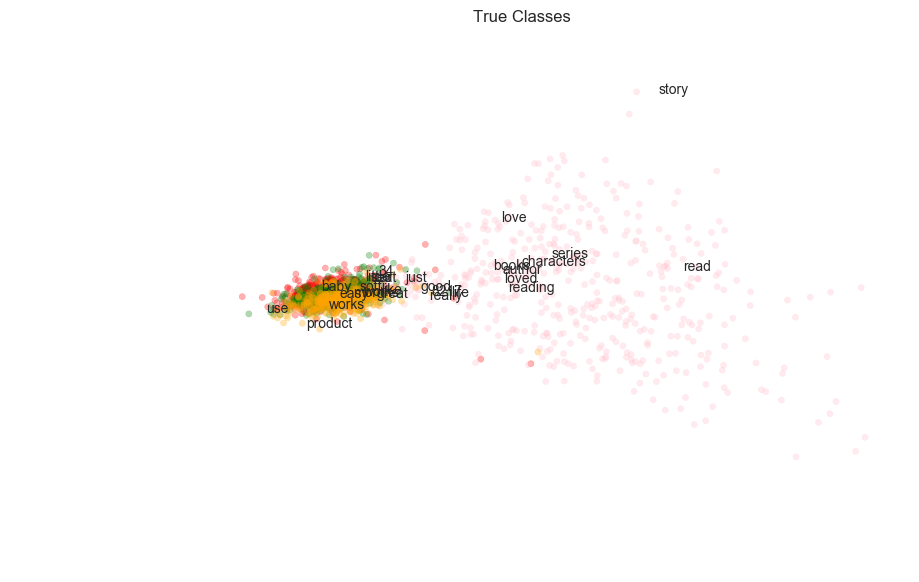

In [169]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
newsgroupsCategories = ['baby','health','home','kindle']
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

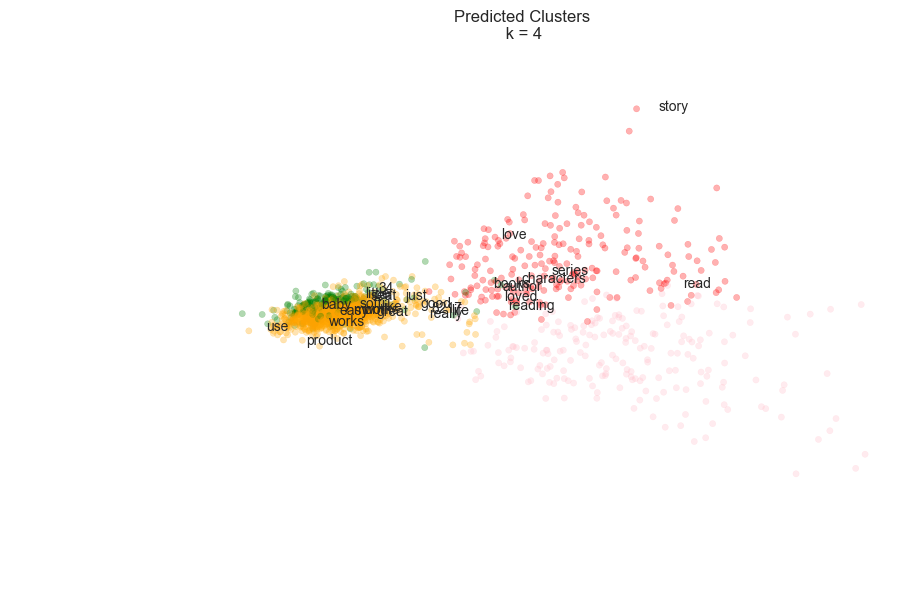

In [170]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.3)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))


plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

In [171]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))
    return silhouette_avg

In [172]:
X = newsgroupsTFVects.toarray()

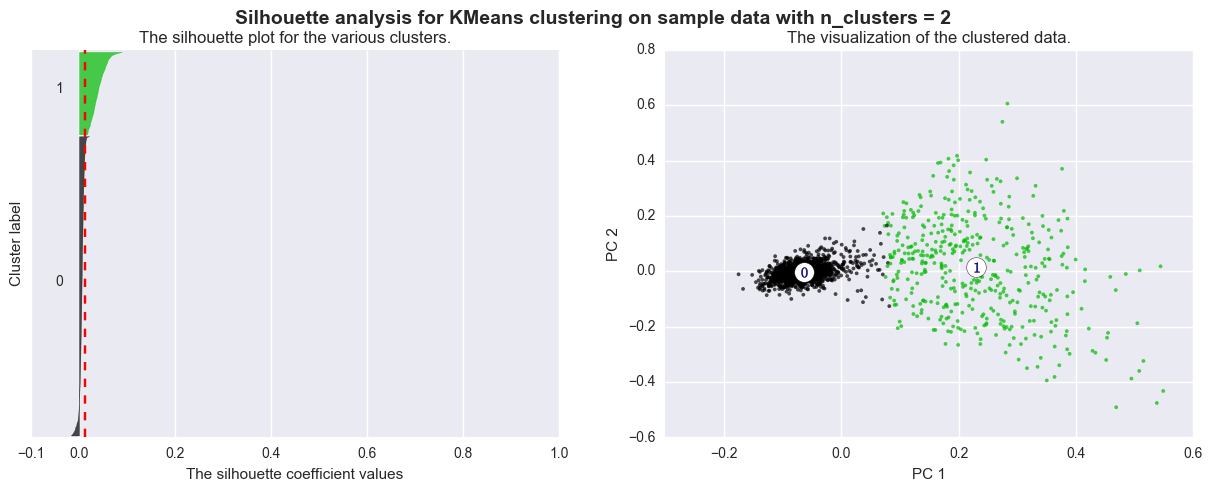

For n_clusters = 2, The average silhouette_score is : 0.013


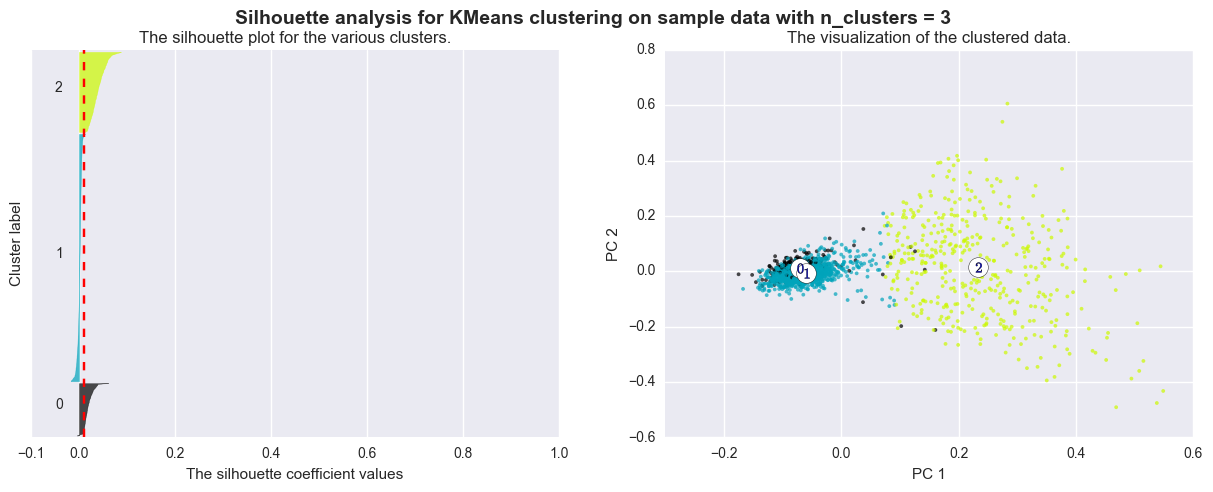

For n_clusters = 3, The average silhouette_score is : 0.011


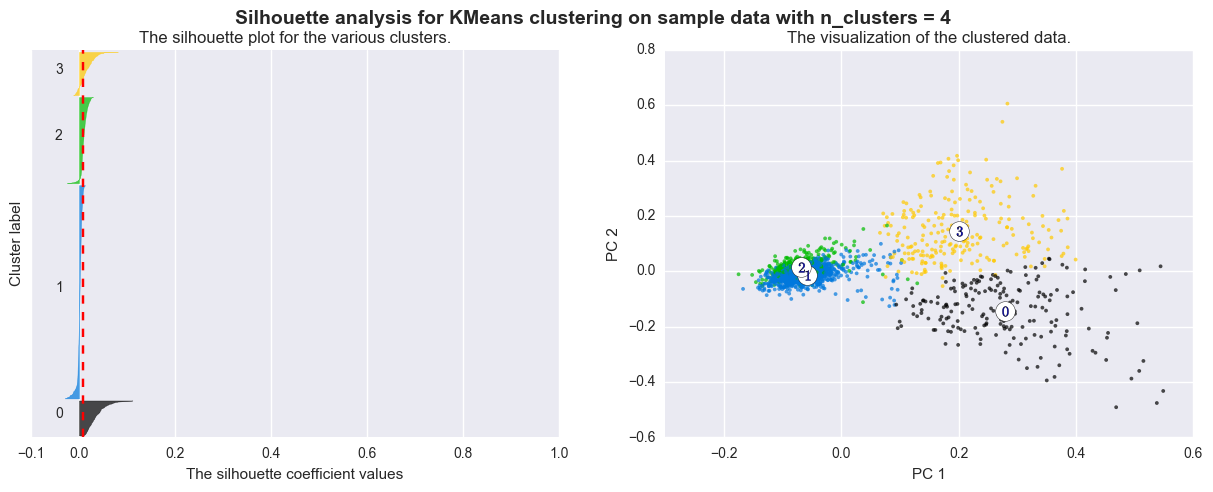

For n_clusters = 4, The average silhouette_score is : 0.008


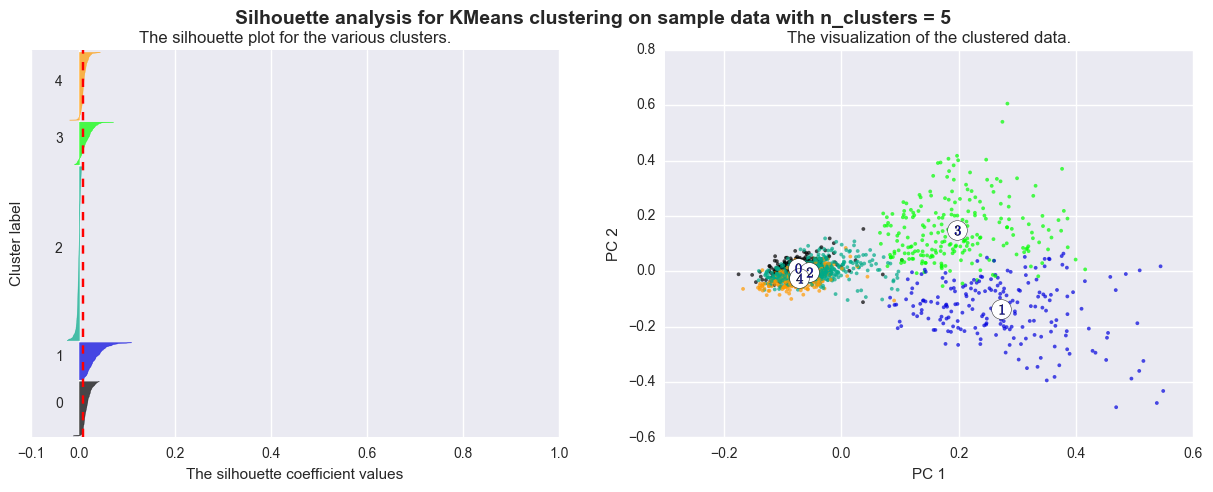

For n_clusters = 5, The average silhouette_score is : 0.008


In [13]:
score_2 = plotSilhouette(2, X)
score_3 = plotSilhouette(3, X)
score_4 = plotSilhouette(4, X)
score_5 = plotSilhouette(5, X)

In [14]:
print("Average silhouette scores for")

print("2 clusters: ", str(score_2))
print("3 clusters: ", str(score_3))
print("4 clusters: ", str(score_4))
print("5 clusters: ", str(score_5))

Average silhouette scores for
2 clusters:  0.0125161965251
3 clusters:  0.0112347885743
4 clusters:  0.00753384338626
5 clusters:  0.00825206251932


## We see from the average silhouette score that 2 clusters seems optimal. Let's see how that looks!

In [173]:
km = sklearn.cluster.KMeans(n_clusters=2, init='k-means++')
km.fit(newsgroupsTFVects)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [175]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')



Top terms per cluster:
Cluster 0:
 book
 story
 read
 series
 love
 characters
 reading
 author
 loved
 books


Cluster 1:
 use
 great
 like
 just
 product
 good
 baby
 easy
 little
 really




## From this, it appears as if the k-means algorithm is clustering reviews into two categories - 'books' and 'others'

## Exercise 2

In [15]:
# Hierarchical Clustering with Wald's Method

newsgroupsTFVects[:100].todense()

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.10066845,  0.        ,  0.12307794, ...,  0.        ,
          0.        ,  0.        ]])

In [16]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)


In [17]:
df = df.reset_index(drop=True)

selectIndices = []
indexToCat = []
for c in set(df['source']):
    selectIndices += list(df[df['source'] == c].index)[:1000]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [19]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())


/Users/sushmitavgopalan/anaconda/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


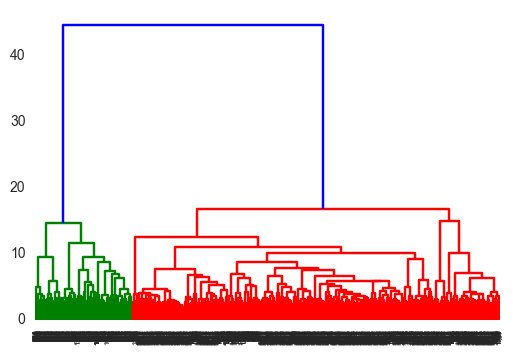

In [20]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

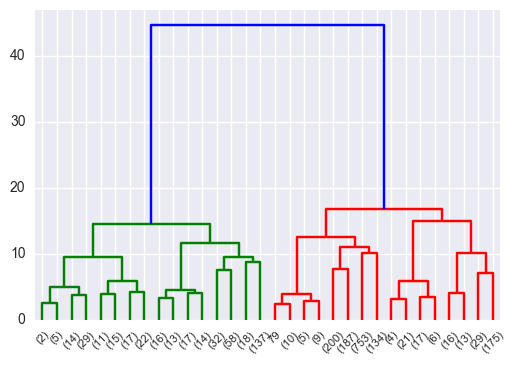

In [21]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

## This appears to support our understanding from Exercise 1 that the data are clustered into two major categories 

In [22]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([2, 2, 4, ..., 2, 4, 2], dtype=int32)

In [24]:
newsgroupsDF = df
newsgroupsDF['category'] = df['source']
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

/Users/sushmitavgopalan/anaconda/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.267
Completeness: 0.391
V-measure: 0.317
Adjusted Rand Score: 0.209


In [25]:
df['wald_predictions'] = hierarchicalClusters_full

## Exercise 3

In [83]:
senReleasesTraining = df


#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['reviewText'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))

In [84]:
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['reviewText'])



In [120]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [121]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

In [122]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

In [123]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

In [182]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')



In [125]:
senReleasesTraining = senReleasesTraining.reset_index(drop=True)


sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['reviewerName'][0]))
print("are: {}".format(sen1lda))

The topics of the text: Amazons frequent shopper
are: [(5, 0.91437744482338834)]


In [113]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['reviewerName'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

In [181]:
warnings.filterwarnings('ignore')
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
ldaDF['name'][1] = "baby1"
ldaDF['name'][2] = "baby2"
ldaDF['name'][3] = "baby3"
ldaDF['name'][501] = "kindle1"
ldaDF['name'][502] = "kindle2"
ldaDF['name'][503] = "kindle3"
ldaDF['name'][1001] = "home1"
ldaDF['name'][1002] = "home2"
ldaDF['name'][1003] = "home3"
ldaDF['name'][1501] = "health1"
ldaDF['name'][1502] = "health2"
ldaDF['name'][1503] = "health3"

In [155]:
ldaDFV = ldaDF.loc[[1,2,3,501,502,503,1001,1001,1003,1501,1502,1503]][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF.loc[[1,2,3,501,502,503,1001,1001,1003,1501,1502,1503]][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,0.012642,0.012438,0.012565,0.012652,0.012506,0.012333,0.012361,0.012630,0.012187,0.887686
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.974382,0.000000,0.000000,0.000000,0.000000
3,0.014804,0.014565,0.014712,0.014815,0.014644,0.014442,0.014474,0.014789,0.869094,0.013661
501,0.000000,0.000000,0.000000,0.097645,0.177122,0.000000,0.000000,0.717346,0.000000,0.000000
502,0.022495,0.022132,0.022357,0.022513,0.801645,0.021946,0.021994,0.022474,0.021684,0.020759
503,0.017857,0.017568,0.017746,0.017871,0.017665,0.017420,0.842343,0.017839,0.017213,0.016478
1001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.948516,0.000000,0.000000,0.000000
1001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.948516,0.000000,0.000000,0.000000
1003,0.000000,0.000000,0.000000,0.000000,0.000000,0.948503,0.000000,0.000000,0.000000,0.000000
1501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.954345


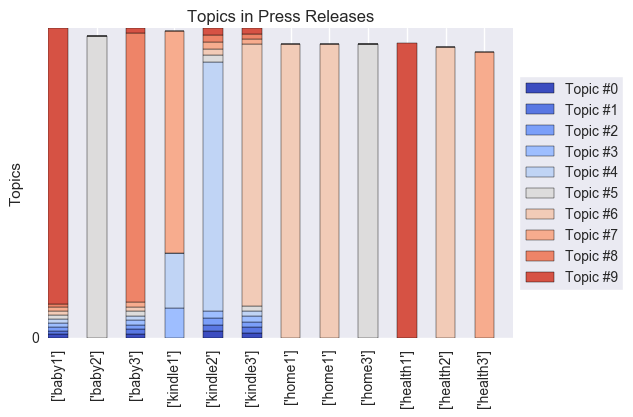

In [156]:
N = 12
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 12))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

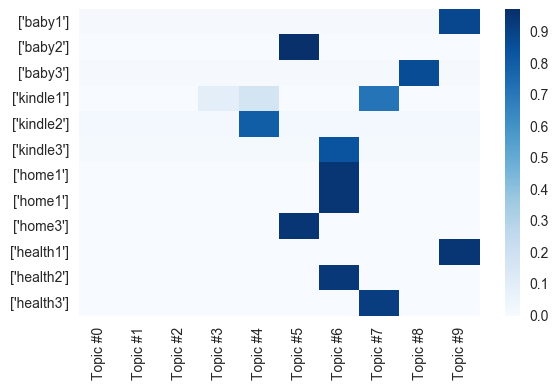

In [157]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [158]:
senlda.show_topic(1)

[('bag', 0.011098366326726131),
 ('vacuum', 0.0091001582118785569),
 ('pillow', 0.008144690754330098),
 ('fit', 0.0064327006705898774),
 ('quick', 0.0060898603484614237),
 ('daughter', 0.0059722526565046457),
 ('month', 0.0057161173213887088),
 ('short', 0.005275125260573923),
 ('tub', 0.0049667199270069301),
 ('toy', 0.0047287109210031571)]

In [159]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,seat,bag,start,fit,review,seat,diaper,hot,shave,author
1,room,vacuum,month,food,life,enjoy,help,page,razor,high
2,mat,pillow,cup,pump,help,pan,author,wash,wait,son
3,night,fit,review,wash,start,month,enjoy,soap,blade,wish
4,wipe,quick,enjoy,month,problem,help,seat,hand,seat,care
5,high,daughter,toy,roll,seat,review,start,turn,help,page
6,brand,month,food,help,hope,quick,review,power,turn,month
7,star,short,author,problem,place,heat,wonder,air,sleep,start
8,bag,tub,high,soft,week,hot,man,problem,problem,help
9,review,toy,son,sheet,item,cover,order,month,room,live


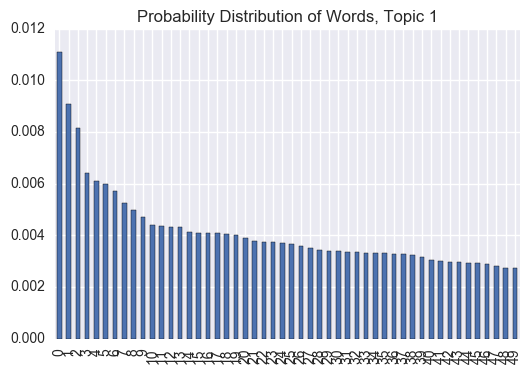

In [160]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

## Hold eta fixed and vary alpha

In [189]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.0001, alpha = 0.9)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.0001, alpha = 0.1)

senlda3 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9, alpha = 0.5)
senlda4 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.0001, alpha = 0.5)


topic11_df = pandas.DataFrame(senlda1.show_topic(2, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(2, topn=50))


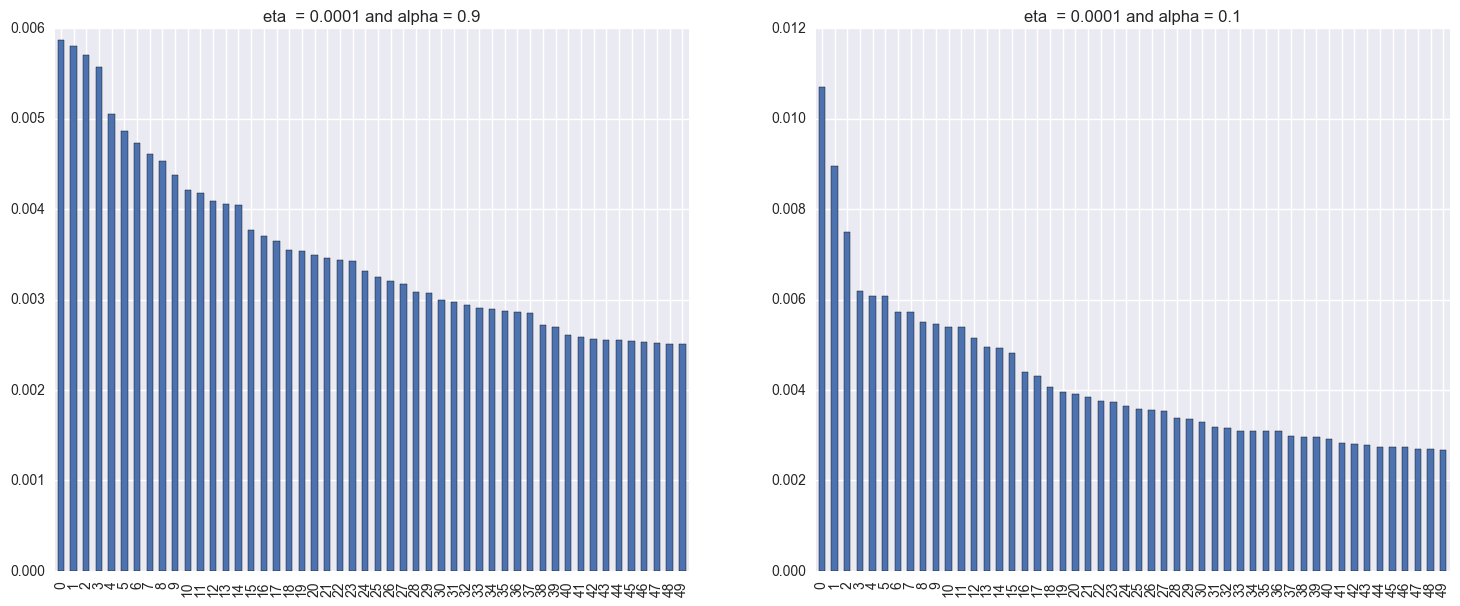

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'eta  = 0.0001 and alpha = 0.9')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'eta  = 0.0001 and alpha = 0.1')
plt.show()

Alpha controls the sparsity of document-topic loadings and as such, a higher value of alpha shows higher probability for each word in topic 1 in each document.

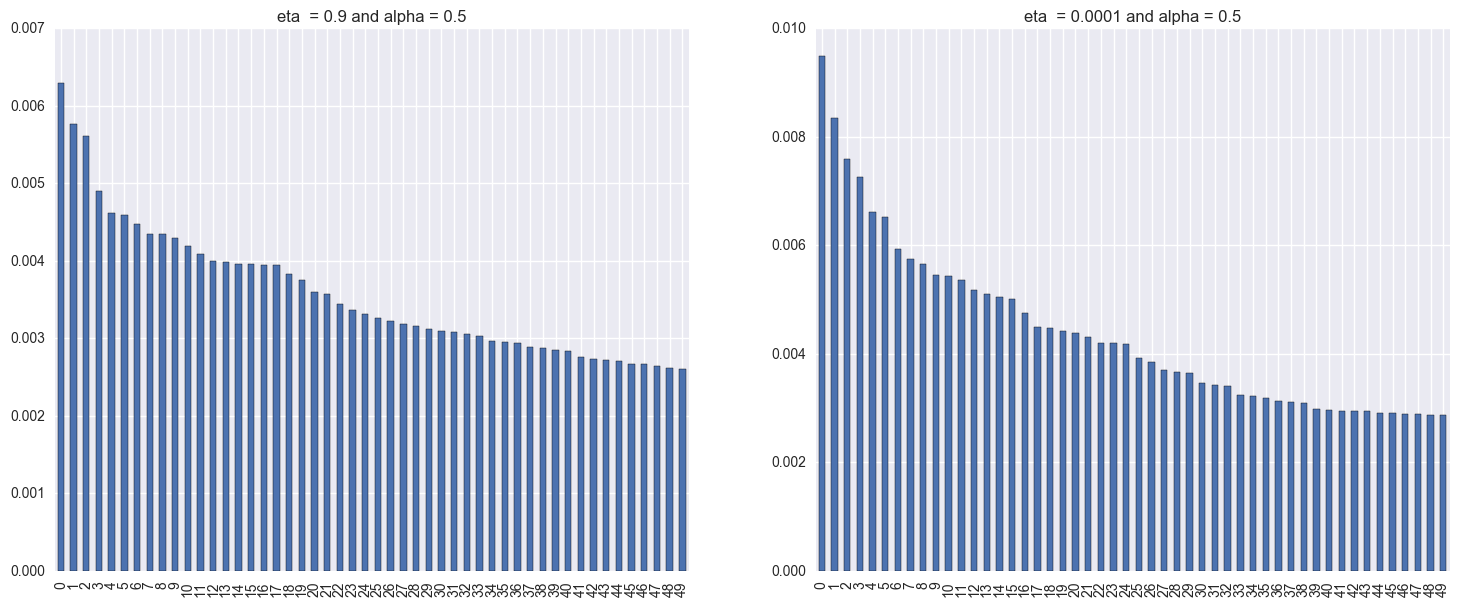

In [190]:
topic31_df = pandas.DataFrame(senlda1.show_topic(2, topn=50))
topic41_df = pandas.DataFrame(senlda2.show_topic(2, topn=50))


fig, (ax3, ax4) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic31_df.plot.bar(legend = False, ax = ax3, title = 'eta  = 0.9 and alpha = 0.5')
topic41_df.plot.bar(legend = False, ax = ax4, title = 'eta  = 0.0001 and alpha = 0.5')
plt.show()

Eta controls the sparsity of topic-word loadings and as such, a higher value of eta shows lower probability for each word in topic 1 across each document

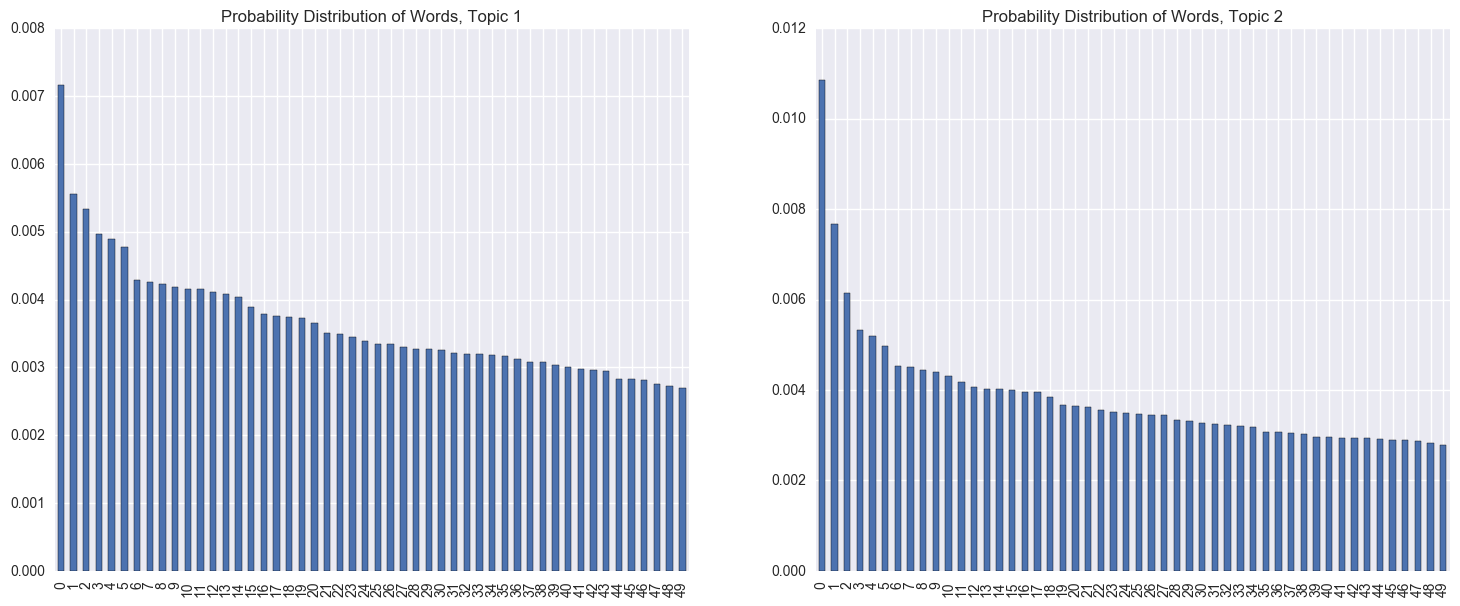

In [191]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
topic2_df = pandas.DataFrame(senlda.show_topic(2, topn=50))

fig, (ax5, ax6) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

topic1_df.plot.bar(legend = False, ax=ax5, title = 'Probability Distribution of Words, Topic 1')
topic2_df.plot.bar(legend = False, ax=ax6, title = 'Probability Distribution of Words, Topic 2')

plt.show()

Topic 1 shows higher probability of each word in each document